In [1]:
# backbone/__init__.py

import math
import torch
import torch.nn as nn

def xavier(m: nn.Module) -> None:
    """
    Applies Xavier initialization to linear modules.
    :param m: the module to be initialized
    Example::
        >>> net = nn.Sequential(nn.Linear(10, 10), nn.ReLU())
        >>> net.apply(xavier)
    """

    if m.__class__.__name__ == 'Linear':
        fan_in = m.weight.data.size(1)
        fan_out = m.weight.data.size(0)
        std = 1.0 * math.sqrt(2.0 / (fan_in + fan_out))
        a = math.sqrt(3.0) * std
        m.weight.data.uniform_(-a, a)
        if m.bias is not None:
            m.bias.data.fill_(0.0)


def num_flat_features(x: torch.Tensor) -> int:
    """
    Computes the total number of items except the first dimension.
    :param x: input tensor
    :return: number of item from the second dimension onward
    """
    size = x.size()[1:]
    num_features = 1
    for ff in size:
        num_features *= ff
    return num_features

In [2]:
# backbone/MNISTMLP.py

import torch
import torch.nn as nn


class MNISTMLP(nn.Module):
    """
    Network composed of two hidden layers, each containing 100 ReLU activations.
    Designed for the MNIST dataset.
    """

    def __init__(self, input_size: int, output_size: int) -> None:
        """
        Instantiates the layers of the network.
        :param input_size: the size of the input data
        :param output_size: the size of the output
        """
        super(MNISTMLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, 100)
        self.fc2 = nn.Linear(100, 100)

        self._features = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU(),
        )
        self.classifier = nn.Linear(100, self.output_size)
        self.net = nn.Sequential(self._features, self.classifier)
        self.reset_parameters()

    def features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the non-activated output of the second-last layer.
        :param x: input tensor (batch_size, input_size)
        :return: output tensor (100)
        """
        x = x.view(-1, num_flat_features(x))
        return self._features(x)

    def reset_parameters(self) -> None:
        """
        Calls the Xavier parameter initialization function.
        """
        self.net.apply(xavier)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute a forward pass.
        :param x: input tensor (batch_size, input_size)
        :return: output tensor (output_size)
        """
        x = x.view(-1, num_flat_features(x))
        return self.net(x)

    def get_params(self) -> torch.Tensor:
        """
        Returns all the parameters concatenated in a single tensor.
        :return: parameters tensor (input_size * 100 + 100 + 100 * 100 + 100 +
                                    + 100 * output_size + output_size)
        """
        params = []
        for pp in list(self.parameters()):
            params.append(pp.view(-1))
        return torch.cat(params)

    def set_params(self, new_params: torch.Tensor) -> None:
        """
        Sets the parameters to a given value.
        :param new_params: concatenated values to be set (input_size * 100
                    + 100 + 100 * 100 + 100 + 100 * output_size + output_size)
        """
        assert new_params.size() == self.get_params().size()
        progress = 0
        for pp in list(self.parameters()):
            cand_params = new_params[progress: progress +
                torch.tensor(pp.size()).prod()].view(pp.size())
            progress += torch.tensor(pp.size()).prod()
            pp.data = cand_params

    def get_grads(self) -> torch.Tensor:
        """
        Returns all the gradients concatenated in a single tensor.
        :return: gradients tensor (input_size * 100 + 100 + 100 * 100 + 100 +
                                   + 100 * output_size + output_size)
        """
        grads = []
        for pp in list(self.parameters()):
            grads.append(pp.grad.view(-1))
        return torch.cat(grads)

    def get_grads_list(self):
        """
        Returns a list containing the gradients (a tensor for each layer).
        :return: gradients list
        """
        grads = []
        for pp in list(self.parameters()):
            grads.append(pp.grad.view(-1))
        return grads

In [3]:
# utils/conf.py

import random
import torch
import numpy as np
import os

def get_device() -> torch.device:
    """
    Returns the GPU device if available else CPU.
    """
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def base_path() -> str:
    """
    Returns the base bath where to log accuracies and tensorboard data.
    """
    return './data/'


def set_random_seed(seed: int) -> None:
    """
    Sets the seeds at a certain value.
    :param seed: the value to be set
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def create_if_not_exists(path: str) -> None:
  """
  Creates the specified folder if it does not exist.
  :param path: the complete path of the folder to be created
  """
  if not os.path.exists(path):
      os.makedirs(path)

In [4]:
# Asses the device used
get_device()

device(type='cpu')

In [5]:
# datasets/utils/validation.py

import torch
from PIL import Image
import numpy as np
import os
import torchvision.transforms.transforms as transforms
from torchvision import datasets


class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data: torch.Tensor, targets: np.ndarray,
        transform: transforms=None, target_transform: transforms=None) -> None:
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        if isinstance(img, np.ndarray):
            if np.max(img) < 2:
                img = Image.fromarray(np.uint8(img * 255))
            else:
                img = Image.fromarray(img)
        else:
            img = Image.fromarray(img.numpy())

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

def get_train_val(train: datasets, test_transform: transforms,
                  dataset: str, val_perc: float=0.1):
    """
    Extract val_perc% of the training set as the validation set.
    :param train: training dataset
    :param test_transform: transformation of the test dataset
    :param dataset: dataset name
    :param val_perc: percentage of the training set to be extracted
    :return: the training set and the validation set
    """
    dataset_length = train.data.shape[0]
    directory = 'datasets/val_permutations/'
    create_if_not_exists(directory)
    file_name = dataset + '.pt'
    if os.path.exists(directory + file_name):
        perm = torch.load(directory + file_name)
    else:
        perm = torch.randperm(dataset_length)
        torch.save(perm, directory + file_name)
    train.data = train.data[perm]
    train.targets = np.array(train.targets)[perm]
    test_dataset = ValidationDataset(train.data[:int(val_perc * dataset_length)],
                                train.targets[:int(val_perc * dataset_length)],
                                transform=test_transform)
    train.data = train.data[int(val_perc * dataset_length):]
    train.targets = train.targets[int(val_perc * dataset_length):]

    return train, test_dataset

In [7]:
# datasets/utils/continual_dataset.py

from abc import abstractmethod
from torch import nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from typing import Tuple
from torchvision import datasets
import numpy as np


class ContinualDataset:
    """
    Continual learning evaluation setting.
    """
    NAME = None
    SETTING = None
    N_CLASSES_PER_TASK = None
    N_TASKS = None
    TRANSFORM = None

    def __init__(self, batch_size: int, validation: bool) -> None:
        """
        Initializes the train and test lists of dataloaders.
        :param args: the arguments which contains the hyperparameters
        """
        self.train_loader = None
        self.test_loaders = []
        self.i = 0
        self.batch_size = batch_size
        self.validation = validation

    @abstractmethod
    def get_data_loaders(self) -> Tuple[DataLoader, DataLoader]:
        """
        Creates and returns the training and test loaders for the current task.
        The current training loader and all test loaders are stored in self.
        :return: the current training and test loaders
        """
        pass

    @abstractmethod
    def not_aug_dataloader(self, batch_size: int) -> DataLoader:
        """
        Returns the dataloader of the current task,
        not applying data augmentation.
        :param batch_size: the batch size of the loader
        :return: the current training loader
        """
        pass

    @staticmethod
    @abstractmethod
    def get_backbone() -> nn.Module:
        """
        Returns the backbone to be used for to the current dataset.
        """
        pass

    @staticmethod
    @abstractmethod
    def get_transform() -> transforms:
        """
        Returns the transform to be used for to the current dataset.
        """
        pass

    @staticmethod
    @abstractmethod
    def get_loss() -> nn.functional:
        """
        Returns the loss to be used for to the current dataset.
        """
        pass

    @staticmethod
    @abstractmethod
    def get_normalization_transform() -> transforms:
        """
        Returns the transform used for normalizing the current dataset.
        """
        pass

    @staticmethod
    @abstractmethod
    def get_denormalization_transform() -> transforms:
        """
        Returns the transform used for denormalizing the current dataset.
        """
        pass


def store_masked_loaders(train_dataset: datasets, test_dataset: datasets,
                    setting: ContinualDataset) -> Tuple[DataLoader, DataLoader]:
    """
    Divides the dataset into tasks.
    :param train_dataset: train dataset
    :param test_dataset: test dataset
    :param setting: continual learning setting
    :return: train and test loaders
    """
    train_mask = np.logical_and(np.array(train_dataset.targets) >= setting.i,
        np.array(train_dataset.targets) < setting.i + setting.N_CLASSES_PER_TASK)
    test_mask = np.logical_and(np.array(test_dataset.targets) >= setting.i,
        np.array(test_dataset.targets) < setting.i + setting.N_CLASSES_PER_TASK)

    train_dataset.data = train_dataset.data[train_mask]
    test_dataset.data = test_dataset.data[test_mask]

    train_dataset.targets = np.array(train_dataset.targets)[train_mask]
    test_dataset.targets = np.array(test_dataset.targets)[test_mask]

    train_loader = DataLoader(train_dataset,
                              batch_size=setting.batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset,
                             batch_size=setting.batch_size, shuffle=False, num_workers=4)
    setting.test_loaders.append(test_loader)
    setting.train_loader = train_loader

    setting.i += setting.N_CLASSES_PER_TASK
    return train_loader, test_loader


def get_previous_train_loader(train_dataset: datasets, batch_size: int,
                              setting: ContinualDataset) -> DataLoader:
    """
    Creates a dataloader for the previous task.
    :param train_dataset: the entire training set
    :param batch_size: the desired batch size
    :param setting: the continual dataset at hand
    :return: a dataloader
    """
    train_mask = np.logical_and(np.array(train_dataset.targets) >=
        setting.i - setting.N_CLASSES_PER_TASK, np.array(train_dataset.targets)
        < setting.i - setting.N_CLASSES_PER_TASK + setting.N_CLASSES_PER_TASK)

    train_dataset.data = train_dataset.data[train_mask]
    train_dataset.targets = np.array(train_dataset.targets)[train_mask]

    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# datasets/MNISTMLP.py

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from PIL import Image
import numpy as np
from typing import Tuple

class MyMNIST(MNIST):
    """
    Overrides the MNIST dataset to change the getitem function.
    """
    def __init__(self, root, train=True, transform=None,
                 target_transform=None, download=False) -> None:
        self.not_aug_transform = transforms.ToTensor()
        super(MyMNIST, self).__init__(root, train,
                                      transform, target_transform, download)

    def __getitem__(self, index: int) -> Tuple[type(Image), int, type(Image)]:
        """
        Gets the requested element from the dataset.
        :param index: index of the element to be returned
        :returns: tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')
        original_img = self.not_aug_transform(img.copy())

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        if hasattr(self, 'logits'):
            return img, target, original_img, self.logits[index]

        return img, target, original_img


class SequentialMNIST(ContinualDataset):

    NAME = 'seq-mnist'
    SETTING = 'class-il'
    N_CLASSES_PER_TASK = 2
    N_TASKS = 5
    TRANSFORM = None

    def get_data_loaders(self):
        transform = transforms.ToTensor()
        train_dataset = MyMNIST(base_path() + 'MNIST',
                                train=True, download=True, transform=transform)
        if self.validation:
            train_dataset, test_dataset = get_train_val(train_dataset,
                                                        transform, self.NAME)
        else:
            test_dataset = MNIST(base_path() + 'MNIST',
                                train=False, download=True, transform=transform)

        train, test = store_masked_loaders(train_dataset, test_dataset, self)
        return train, test

    def not_aug_dataloader(self, batch_size):
        transform = transforms.ToTensor()
        train_dataset = MyMNIST(base_path() + 'MNIST',
                                train=True, download=True, transform=transform)
        train_mask = np.logical_and(np.array(train_dataset.targets) >= self.i -
            self.N_CLASSES_PER_TASK, np.array(train_dataset.targets) < self.i)

        train_dataset.data = train_dataset.data[train_mask]
        train_dataset.targets = np.array(train_dataset.targets)[train_mask]

        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size, shuffle=True)
        return train_loader

    @staticmethod
    def get_backbone():
        return MNISTMLP(28 * 28, SequentialMNIST.N_TASKS
                        * SequentialMNIST.N_CLASSES_PER_TASK)

    @staticmethod
    def get_transform():
        return None

    @staticmethod
    def get_loss():
        return F.cross_entropy

    @staticmethod
    def get_normalization_transform():
        return None

    @staticmethod
    def get_denormalization_transform():
        return None

In [9]:
NAMES = {
    SequentialMNIST.NAME: SequentialMNIST,
    #SequentialCIFAR10.NAME: SequentialCIFAR10
}


def get_dataset(dataset: str, batch_size: int, validation: bool) -> ContinualDataset:
    """
    Creates and returns a continual dataset.
    :param args: the arguments which contains the hyperparameters
    :return: the continual dataset
    """
    assert dataset in NAMES.keys()
    return NAMES[dataset](batch_size, validation)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MyMNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MyMNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MyMNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MyMNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MyMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MyMNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MyMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MyMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


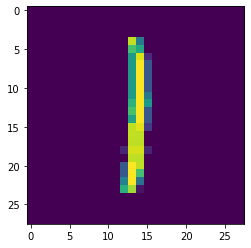

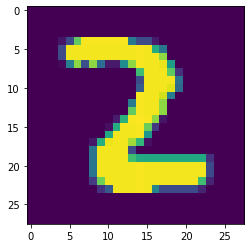

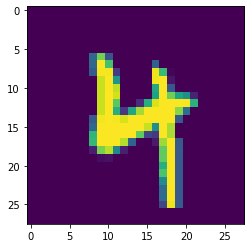

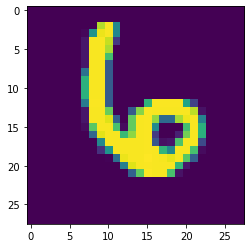

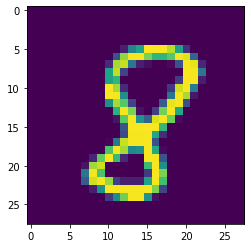

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
dataset = get_dataset("seq-mnist", 256, True)
data_loaders = []
for i in range(5):
  data_loaders.append(dataset.get_data_loaders())
for i in range(5):
  imgplot = plt.imshow(data_loaders[i][0].dataset[0][0].squeeze_(0))
  plt.show()

# data_loaders[num_task][0 --> train, 1 --> test].dataset[campione][0 --> img, 1 --> label]

In [11]:
# models/utils/continual_model.py

import torch.nn as nn
from torch.optim import SGD
import torch
import torchvision

class ContinualModel(nn.Module):
    """
    Continual learning model.
    """
    NAME = None
    COMPATIBILITY = []

    def __init__(self, backbone: nn.Module, loss: nn.Module,
                lr: float, buffer_size: int, minibatch_size: int, alpha: float, transform: torchvision.transforms) -> None:
        super(ContinualModel, self).__init__()

        self.net = backbone
        self.loss = loss
        self.lr = lr
        self.buffer_size = buffer_size
        self.minibatch_size = minibatch_size
        self.alpha = alpha
        self.transform = transform
        self.opt = SGD(self.net.parameters(), lr=self.lr)
        self.device = get_device()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Computes a forward pass.
        :param x: batch of inputs
        :param task_label: some models require the task label
        :return: the result of the computation
        """
        return self.net(x)

    def observe(self, inputs: torch.Tensor, labels: torch.Tensor,
                not_aug_inputs: torch.Tensor) -> float:
        """
        Compute a training step over a given batch of examples.
        :param inputs: batch of examples
        :param labels: ground-truth labels
        :param kwargs: some methods could require additional parameters
        :return: the value of the loss function
        """
        pass

In [12]:
# models/sgd.py

class Sgd(ContinualModel):
    NAME = 'sgd'
    COMPATIBILITY = ['class-il', 'domain-il', 'task-il', 'general-continual']

    def __init__(self, backbone, loss, lr, buffer_size, minibatch_size, alpha, transform):
        super(Sgd, self).__init__(backbone, loss, lr, buffer_size, minibatch_size, alpha, transform)
        print(self.net)

    def observe(self, inputs, labels, not_aug_inputs):
        self.opt.zero_grad()
        outputs = self.net(inputs)
        loss = self.loss(outputs, labels)
        loss.backward()
        self.opt.step()

        return loss.item()

In [13]:
# models/__init__.py

import os
import importlib

models = ["sgd.py", "der.py"]

def get_all_models():
    return [model.split('.')[0] for model in models
            if not model.find('__') > -1 and 'py' in model]

def get_model(model, backbone, loss, lr, buffer_size, minibatch_size, alpha, transform):
    return model(backbone, loss, lr, buffer_size, minibatch_size, alpha, transform)

In [14]:
# utils/status.py

from datetime import datetime
import sys
import os
from typing import Any, Dict, Union
from torch import nn

def progress_bar(i: int, max_iter: int, epoch: Union[int, str],
                 task_number: int, loss: float) -> None:
    """
    Prints out the progress bar on the stderr file.
    :param i: the current iteration
    :param max_iter: the maximum number of iteration
    :param epoch: the epoch
    :param task_number: the task index
    :param loss: the current value of the loss function
    """
    if not (i + 1) % 10 or (i + 1) == max_iter:
        progress = min(float((i + 1) / max_iter), 1)
        progress_bar = ('█' * int(50 * progress)) + ('┈' * (50 - int(50 * progress)))
        print('\r[ {} ] Task {} | epoch {}: |{}| loss: {}'.format(
            datetime.now().strftime("%m-%d | %H:%M"),
            task_number + 1 if isinstance(task_number, int) else task_number,
            epoch,
            progress_bar,
            round(loss, 8)
        ), file=sys.stderr, end='', flush=True)

In [15]:
# utils/loggers.py

import os
import sys
import numpy as np

def print_mean_accuracy(mean_acc: np.ndarray, task_number: int,
                        setting: str) -> None:
    """
    Prints the mean accuracy on stderr.
    :param mean_acc: mean accuracy value
    :param task_number: task index
    :param setting: the setting of the benchmark
    """
    if setting == 'domain-il':
        mean_acc, _ = mean_acc
        print('\nAccuracy for {} task(s): {} %'.format(
            task_number, round(mean_acc, 2)), file=sys.stderr)
    else:
        mean_acc_class_il, mean_acc_task_il = mean_acc
        print('\nAccuracy for {} task(s): \t [Class-IL]: {} %'
              ' \t [Task-IL]: {} %\n'.format(task_number, round(
            mean_acc_class_il, 2), round(mean_acc_task_il, 2)), file=sys.stderr)



In [16]:
# utils/training.py

import torch
from typing import Tuple
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def mask_classes(outputs: torch.Tensor, dataset: ContinualDataset, k: int) -> None:
    """
    Given the output tensor, the dataset at hand and the current task,
    masks the former by setting the responses for the other tasks at -inf.
    It is used to obtain the results for the task-il setting.
    :param outputs: the output tensor
    :param dataset: the continual dataset
    :param k: the task index
    """
    outputs[:, 0:k * dataset.N_CLASSES_PER_TASK] = -float('inf')
    outputs[:, (k + 1) * dataset.N_CLASSES_PER_TASK:
               dataset.N_TASKS * dataset.N_CLASSES_PER_TASK] = -float('inf')


def evaluate(model: ContinualModel, dataset: ContinualDataset, last=False) -> Tuple[list, list]:
    """
    Evaluates the accuracy of the model for each past task.
    :param model: the model to be evaluated
    :param dataset: the continual dataset at hand
    :return: a tuple of lists, containing the class-il
             and task-il accuracy for each task
    """
    status = model.net.training
    model.net.eval()
    accs, accs_mask_classes = [], []
    for k, test_loader in enumerate(dataset.test_loaders):
      # k = indice del task (da 0 a 4), last = flag per indicare l'ultimo task corrente
      # il numero di test_loader è di 5 (quanti i task)
        if last and k < len(dataset.test_loaders) - 1:
            continue
        correct, correct_mask_classes, total = 0.0, 0.0, 0.0
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            if 'class-il' not in model.COMPATIBILITY:
                outputs = model(inputs, k) # fornisco anche l'indice del task
            else:
                outputs = model(inputs) # shape = [256, 10], tranne per l'ultimo mini-batch

            _, pred = torch.max(outputs.data, 1) # label predette dal modello (batch di 256, tranne l'ultimo)
            correct += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette
            total += labels.shape[0] # numero di campioni totali valutati fino a questo momento per il task corrente

            if dataset.SETTING == 'class-il': # con seq-mnist siamo in questo scenario
                mask_classes(outputs, dataset, k) # maschero gli output delle classi non appartenenti al task corrente (per lo scenario Task IL)
                _, pred = torch.max(outputs.data, 1)
                correct_mask_classes += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette per lo scenario T-IL
        
        # Calcolo l'accuratezza per i due scenari (C-IL e T-IL)
        accs.append(correct / total * 100
                    if 'class-il' in model.COMPATIBILITY else 0)
        accs_mask_classes.append(correct_mask_classes / total * 100)

    model.net.train(status)
    return accs, accs_mask_classes


def train(model: ContinualModel, dataset: ContinualDataset, n_epochs: int, checkpoint_epoch: int, task: int) -> None:
    """
    The training process, including evaluations and loggers.
    :param model: the module to be trained
    :param dataset: the continual dataset at hand
    :param args: the arguments of the current execution
    """
    model.net.to(model.device)
    results, results_mask_classes = [], []
    accuracy = []
    total_loss = []

    for t in range(dataset.N_TASKS):
        model.net.train()
        train_loader, test_loader = dataset.get_data_loaders()
        if t:
            accs = evaluate(model, dataset, last=True)
            results[t-1] = results[t-1] + accs[0]
            if dataset.SETTING == 'class-il':
                results_mask_classes[t-1] = results_mask_classes[t-1] + accs[1] # salvo anche le accuratezze per lo scenario T-IL

        if task is not None:
            if t < task: 
              # Load parameters
              weights_directory = "/home/marco_palumbo/saved_models/DER/model_%d_epoch_%d_task.pt" % (checkpoint_epoch, t)
              model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
        else: 
          checkpoint_epoch = 0
        for epoch in range(checkpoint_epoch, n_epochs):
            sum_classification_loss = 0
            for i, data in enumerate(train_loader):
                if hasattr(dataset.train_loader.dataset, 'logits'):
                    inputs, labels, not_aug_inputs, logits = data
                    inputs = inputs.to(model.device)
                    labels = labels.to(model.device)
                    not_aug_inputs = not_aug_inputs.to(model.device)
                    logits = logits.to(model.device)
                    loss = model.observe(inputs, labels, not_aug_inputs, logits)
                    sum_classification_loss += loss
                else:
                    inputs, labels, not_aug_inputs = data
                    inputs, labels = inputs.to(model.device), labels.to(
                        model.device)
                    not_aug_inputs = not_aug_inputs.to(model.device)
                    loss = model.observe(inputs, labels, not_aug_inputs)
                    sum_classification_loss += loss

                progress_bar(i, len(train_loader), epoch, t, loss)
                # Save parameters every 10 epochs
                #if(epoch % 10 == 0 or epoch == 49):
                  #torch.save(model.state_dict(), "/home/marco_palumbo/saved_models/DER/model_%d_epoch_%d_task.pt" % (epoch, t))
            total_loss.append(sum_classification_loss / len(train_loader))
        accs = evaluate(model, dataset) # calcolo dell'accuratezza
        results.append(accs[0]) # accuratezza per C-IL
        results_mask_classes.append(accs[1]) # accuratezza per T-IL

        mean_acc = np.mean(accs, axis=1) # calcolo l'accuratezza media (acc / num_task)
        accuracy.append(mean_acc)
        print_mean_accuracy(mean_acc, t + 1, dataset.SETTING)

  
    # Plotting dell'accuratezza media
    plt.figure(figsize=(10,5))
    plt.title("Accuracy over tasks")
    plt.plot([1, 2, 3, 4, 5], accuracy) # Num task vs accuracy
    plt.legend(loc="lower left")
    plt.gca().legend(('C-IL Accuracy','T-IL Accuracy'))
    
    # Plotting della loss
    ax = plt.figure(figsize=(10,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Loss over tasks")
    plt.plot(np.arange(len(total_loss)), total_loss, label='Classification loss')
    plt.legend(loc="upper right")

In [ ]:
# Train using SGD model
dataset = get_dataset("seq-mnist", 10, True)
model = get_model(Sgd, backbone=dataset.get_backbone(), loss=dataset.get_loss(), lr=0.03, buffer_size=None, minibatch_size=None, alpha=None, transform=dataset.get_transform())
train(model, dataset, 1, None, None)

# Training with DER

In [18]:
# utils/buffer.py

import torch
import numpy as np
from typing import Tuple
from torchvision import transforms


def reservoir(num_seen_examples: int, buffer_size: int) -> int:
    """
    Reservoir sampling algorithm.
    :param num_seen_examples: the number of seen examples
    :param buffer_size: the maximum buffer size
    :return: the target index if the current image is sampled, else -1
    """
    if num_seen_examples < buffer_size:
        return num_seen_examples

    rand = np.random.randint(0, num_seen_examples + 1)
    if rand < buffer_size:
        return rand
    else:
        return -1


def ring(num_seen_examples: int, buffer_portion_size: int, task: int) -> int:
    return num_seen_examples % buffer_portion_size + task * buffer_portion_size


class Buffer:
    """
    The memory buffer of rehearsal method.
    """
    def __init__(self, buffer_size, device, n_tasks=None, mode='reservoir'):
        assert mode in ['ring', 'reservoir']
        self.buffer_size = buffer_size
        self.device = device
        self.num_seen_examples = 0
        self.functional_index = eval(mode)
        if mode == 'ring':
            assert n_tasks is not None
            self.task_number = n_tasks
            self.buffer_portion_size = buffer_size // n_tasks
        self.attributes = ['examples', 'labels', 'logits', 'task_labels']

    def init_tensors(self, examples: torch.Tensor, labels: torch.Tensor,
                     logits: torch.Tensor, task_labels: torch.Tensor) -> None:
        """
        Initializes just the required tensors.
        :param examples: tensor containing the images
        :param labels: tensor containing the labels
        :param logits: tensor containing the outputs of the network
        :param task_labels: tensor containing the task labels
        """
        for attr_str in self.attributes:
            attr = eval(attr_str)
            if attr is not None and not hasattr(self, attr_str):
                typ = torch.int64 if attr_str.endswith('els') else torch.float32
                setattr(self, attr_str, torch.zeros((self.buffer_size,
                        *attr.shape[1:]), dtype=typ, device=self.device))

    def add_data(self, examples, labels=None, logits=None, task_labels=None):
        """
        Adds the data to the memory buffer according to the reservoir strategy.
        :param examples: tensor containing the images
        :param labels: tensor containing the labels
        :param logits: tensor containing the outputs of the network
        :param task_labels: tensor containing the task labels
        :return:
        """
        if not hasattr(self, 'examples'):
            self.init_tensors(examples, labels, logits, task_labels)

        for i in range(examples.shape[0]):
            index = reservoir(self.num_seen_examples, self.buffer_size)
            self.num_seen_examples += 1
            if index >= 0:
                self.examples[index] = examples[i].to(self.device)
                if labels is not None:
                    self.labels[index] = labels[i].to(self.device)
                if logits is not None:
                    self.logits[index] = logits[i].to(self.device)
                if task_labels is not None:
                    self.task_labels[index] = task_labels[i].to(self.device)

    def get_data(self, size: int, transform: transforms=None) -> Tuple:
        """
        Random samples a batch of size items.
        :param size: the number of requested items
        :param transform: the transformation to be applied (data augmentation)
        :return:
        """
        if size > min(self.num_seen_examples, self.examples.shape[0]):
            size = min(self.num_seen_examples, self.examples.shape[0])

        choice = np.random.choice(min(self.num_seen_examples, self.examples.shape[0]),
                                  size=size, replace=False)
        if transform is None: transform = lambda x: x
        ret_tuple = (torch.stack([transform(ee.cpu())
                            for ee in self.examples[choice]]).to(self.device),)
        for attr_str in self.attributes[1:]:
            if hasattr(self, attr_str):
                attr = getattr(self, attr_str)
                ret_tuple += (attr[choice],)

        return ret_tuple

    def is_empty(self) -> bool:
        """
        Returns true if the buffer is empty, false otherwise.
        """
        if self.num_seen_examples == 0:
            return True
        else:
            return False

    def get_all_data(self, transform: transforms=None) -> Tuple:
        """
        Return all the items in the memory buffer.
        :param transform: the transformation to be applied (data augmentation)
        :return: a tuple with all the items in the memory buffer
        """
        if transform is None: transform = lambda x: x
        ret_tuple = (torch.stack([transform(ee.cpu())
                            for ee in self.examples]).to(self.device),)
        for attr_str in self.attributes[1:]:
            if hasattr(self, attr_str):
                attr = getattr(self, attr_str)
                ret_tuple += (attr,)
        return ret_tuple

    def empty(self) -> None:
        """
        Set all the tensors to None.
        """
        for attr_str in self.attributes:
            if hasattr(self, attr_str):
                delattr(self, attr_str)
        self.num_seen_examples = 0

In [20]:
# models/der.py

from torch.nn import functional as F

class Der(ContinualModel):
    NAME = 'der'
    COMPATIBILITY = ['class-il', 'domain-il', 'task-il', 'general-continual']

    def __init__(self, backbone, loss, lr, buffer_size, minibatch_size, alpha, transform):
        super(Der, self).__init__(backbone, loss, lr, buffer_size, minibatch_size, alpha, transform)
        self.buffer = Buffer(self.buffer_size, self.device)

    def observe(self, inputs, labels, not_aug_inputs):

        self.opt.zero_grad()

        outputs = self.net(inputs)
        loss = self.loss(outputs, labels)

        if not self.buffer.is_empty():
            buf_inputs, buf_logits = self.buffer.get_data(
                self.minibatch_size, transform=self.transform)
            buf_outputs = self.net(buf_inputs)
            loss += self.alpha * F.mse_loss(buf_outputs, buf_logits)

        loss.backward()
        self.opt.step()
        self.buffer.add_data(examples=not_aug_inputs, logits=outputs.data)

        return loss.item()

[ 01-07 | 10:51 ] Task 1 | epoch 0: |██████████████████████████████████████████████████| loss: 0.12380641
Accuracy for 1 task(s): 	 [Class-IL]: 99.68 % 	 [Task-IL]: 99.68 %

[ 01-07 | 10:52 ] Task 2 | epoch 0: |██████████████████████████████████████████████████| loss: 0.12065108
Accuracy for 2 task(s): 	 [Class-IL]: 97.59 % 	 [Task-IL]: 98.86 %

[ 01-07 | 10:52 ] Task 3 | epoch 0: |██████████████████████████████████████████████████| loss: 0.41463727
Accuracy for 3 task(s): 	 [Class-IL]: 95.41 % 	 [Task-IL]: 99.04 %

[ 01-07 | 10:52 ] Task 4 | epoch 0: |██████████████████████████████████████████████████| loss: 0.10708636
Accuracy for 4 task(s): 	 [Class-IL]: 94.24 % 	 [Task-IL]: 98.91 %

[ 01-07 | 10:52 ] Task 5 | epoch 0: |██████████████████████████████████████████████████| loss: 0.10101603
Accuracy for 5 task(s): 	 [Class-IL]: 90.69 % 	 [Task-IL]: 98.82 %

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() i

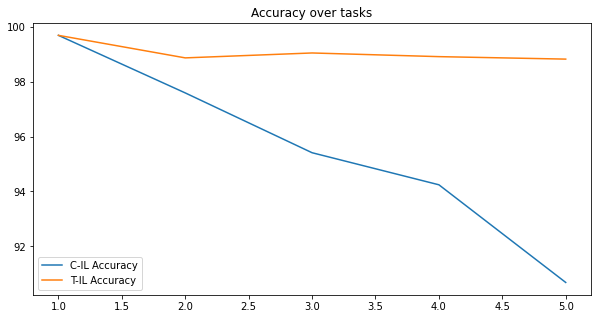

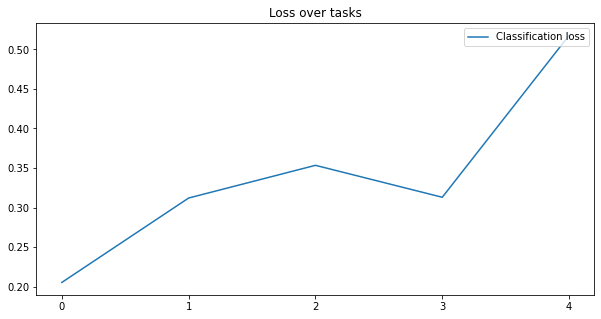

In [ ]:
# Train using DER model on MNIST
dataset = get_dataset("seq-mnist", 10, True)
model = get_model(Der, backbone=dataset.get_backbone(), loss=dataset.get_loss(), lr=0.03, buffer_size=500, minibatch_size=128, alpha=1.0, transform=dataset.get_transform())
train(model, dataset, 1, None, None)

# CIFAR-10

In [21]:
# ResNet18.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu, avg_pool2d
from typing import List


def conv3x3(in_planes: int, out_planes: int, stride: int=1) -> F.conv2d:
    """
    Instantiates a 3x3 convolutional layer with no bias.
    :param in_planes: number of input channels
    :param out_planes: number of output channels
    :param stride: stride of the convolution
    :return: convolutional layer
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    """
    The basic block of ResNet.
    """
    expansion = 1

    def __init__(self, in_planes: int, planes: int, stride: int=1) -> None:
        """
        Instantiates the basic block of the network.
        :param in_planes: the number of input channels
        :param planes: the number of channels (to be possibly expanded)
        """
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute a forward pass.
        :param x: input tensor (batch_size, input_size)
        :return: output tensor (10)
        """
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out


class ResNet(nn.Module):
    """
    ResNet network architecture. Designed for complex datasets.
    """

    def __init__(self, block: BasicBlock, num_blocks: List[int],
                 num_classes: int, nf: int) -> None:
        """
        Instantiates the layers of the network.
        :param block: the basic ResNet block
        :param num_blocks: the number of blocks per layer
        :param num_classes: the number of output classes
        :param nf: the number of filters
        """
        super(ResNet, self).__init__()
        self.in_planes = nf
        self.block = block
        self.num_classes = num_classes
        self.nf = nf
        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)

        self._features = nn.Sequential(self.conv1,
                                       self.bn1,
                                       nn.ReLU(),
                                       self.layer1,
                                       self.layer2,
                                       self.layer3,
                                       self.layer4
                                       )
        self.classifier = self.linear

    def _make_layer(self, block: BasicBlock, planes: int,
                    num_blocks: int, stride: int) -> nn.Module:
        """
        Instantiates a ResNet layer.
        :param block: ResNet basic block
        :param planes: channels across the network
        :param num_blocks: number of blocks
        :param stride: stride
        :return: ResNet layer
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute a forward pass.
        :param x: input tensor (batch_size, *input_shape)
        :return: output tensor (output_classes)
        """
        out = relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)  # 64, 32, 32
        out = self.layer2(out)  # 128, 16, 16
        out = self.layer3(out)  # 256, 8, 8
        out = self.layer4(out)  # 512, 4, 4
        out = avg_pool2d(out, out.shape[2]) # 512, 1, 1
        out = out.view(out.size(0), -1)  # 512
        out = self.linear(out)
        return out

    def features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the non-activated output of the second-last layer.
        :param x: input tensor (batch_size, *input_shape)
        :return: output tensor (??)
        """
        out = self._features(x)
        out = avg_pool2d(out, out.shape[2])
        feat = out.view(out.size(0), -1)
        return feat

    def get_params(self) -> torch.Tensor:
        """
        Returns all the parameters concatenated in a single tensor.
        :return: parameters tensor (??)
        """
        params = []
        for pp in list(self.parameters()):
            params.append(pp.view(-1))
        return torch.cat(params)

    def set_params(self, new_params: torch.Tensor) -> None:
        """
        Sets the parameters to a given value.
        :param new_params: concatenated values to be set (??)
        """
        assert new_params.size() == self.get_params().size()
        progress = 0
        for pp in list(self.parameters()):
            cand_params = new_params[progress: progress +
                torch.tensor(pp.size()).prod()].view(pp.size())
            progress += torch.tensor(pp.size()).prod()
            pp.data = cand_params

    def get_grads(self) -> torch.Tensor:
        """
        Returns all the gradients concatenated in a single tensor.
        :return: gradients tensor (??)
        """
        grads = []
        for pp in list(self.parameters()):
            grads.append(pp.grad.view(-1))
        return torch.cat(grads)


def resnet18(nclasses: int, nf: int=64) -> ResNet:
    """
    Instantiates a ResNet18 network.
    :param nclasses: number of output classes
    :param nf: number of filters
    :return: ResNet network
    """
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf)

In [22]:
# denormalization.py

class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [23]:
# seq_cifar10.py

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
from typing import Tuple

class MyCIFAR10(CIFAR10):
    """
    Overrides the CIFAR10 dataset to change the getitem function.
    """
    def __init__(self, root, train=True, transform=None,
                 target_transform=None, download=False) -> None:
        self.not_aug_transform = transforms.Compose([transforms.ToTensor()])
        super(MyCIFAR10, self).__init__(root, train, transform, target_transform, download)

    def __getitem__(self, index: int) -> Tuple[type(Image), int, type(Image)]:
        """
        Gets the requested element from the dataset.
        :param index: index of the element to be returned
        :returns: tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # to return a PIL Image
        img = Image.fromarray(img, mode='RGB')
        original_img = img.copy()

        not_aug_img = self.not_aug_transform(original_img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        if hasattr(self, 'logits'):
            return img, target, not_aug_img, self.logits[index]

        return img, target, not_aug_img


class SequentialCIFAR10(ContinualDataset):

    NAME = 'seq-cifar10'
    SETTING = 'class-il'
    N_CLASSES_PER_TASK = 2
    N_TASKS = 5
    TRANSFORM = transforms.Compose(
            [transforms.RandomCrop(32, padding=4),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    #TRANSFORM = transforms.Compose([transforms.ToTensor()])                       

    def get_data_loaders(self):
        transform = self.TRANSFORM

        test_transform = transforms.Compose(
            [transforms.ToTensor(), self.get_normalization_transform()])

        train_dataset = MyCIFAR10(base_path() + 'CIFAR10', train=True,
                                  download=True, transform=transform)
        if self.validation:
            train_dataset, test_dataset = get_train_val(train_dataset,
                                                    test_transform, self.NAME)
        else:
            test_dataset = CIFAR10(base_path() + 'CIFAR10',train=False,
                                   download=True, transform=test_transform)

        train, test = store_masked_loaders(train_dataset, test_dataset, self)
        return train, test

    def not_aug_dataloader(self, batch_size):
        transform = transforms.Compose([transforms.ToTensor(), self.get_normalization_transform()])

        train_dataset = MyCIFAR10(base_path() + 'CIFAR10', train=True,
                                  download=True, transform=transform)
        train_loader = get_previous_train_loader(train_dataset, batch_size, self)

        return train_loader

    @staticmethod
    def get_transform():
        transform = transforms.Compose(
            [transforms.ToPILImage(), SequentialCIFAR10.TRANSFORM])
        return transform

    @staticmethod
    def get_backbone():
        return resnet18(SequentialCIFAR10.N_CLASSES_PER_TASK
                        * SequentialCIFAR10.N_TASKS)

    @staticmethod
    def get_loss():
        return F.cross_entropy

    @staticmethod
    def get_normalization_transform():
        transform = transforms.Normalize((0.4914, 0.4822, 0.4465),
                                         (0.2470, 0.2435, 0.2615))
        return transform

    @staticmethod
    def get_denormalization_transform():
        transform = DeNormalize((0.4914, 0.4822, 0.4465),
                                (0.2470, 0.2435, 0.2615))
        return transform

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


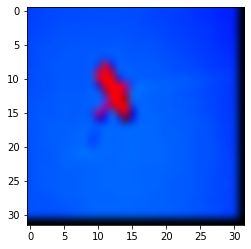

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


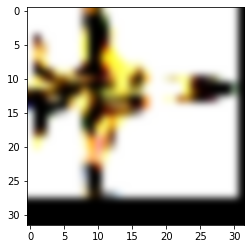

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


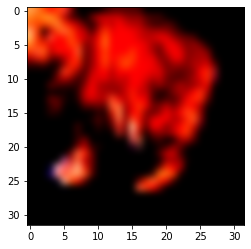

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


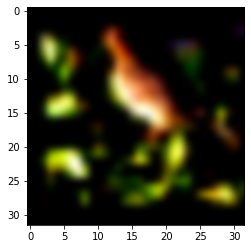

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


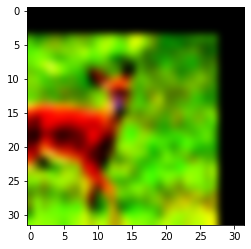

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


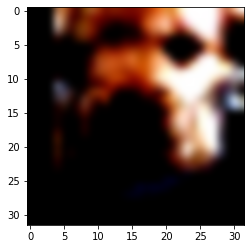

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


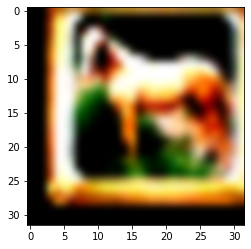

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


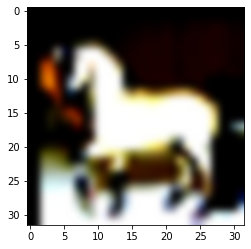

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


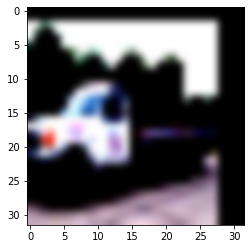

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


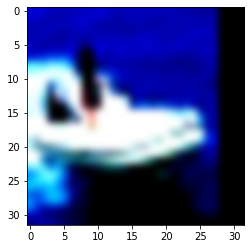

In [24]:
# Show images
import torchvision.transforms.transforms as transforms
NAMES[SequentialCIFAR10.NAME] = SequentialCIFAR10
dataset_cifar = get_dataset("seq-cifar10", 256, True)
for i in range(dataset_cifar.N_TASKS):
  train_loader, test_loader, = dataset_cifar.get_data_loaders()
  for j in range(dataset_cifar.N_CLASSES_PER_TASK):
    img = train_loader.dataset[j][0].permute(1, 2, 0)
    plt.imshow(img, interpolation="bicubic")
    plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
[ 11-07 | 09:46 ] Task 1 | epoch 49: |██████████████████████████████████████████████████| loss: 0.0257679
Accuracy for 1 task(s): 	 [Class-IL]: 99.4 % 	 [Task-IL]: 99.4 %



Files already downloaded and verified


[ 11-07 | 10:04 ] Task 2 | epoch 49: |██████████████████████████████████████████████████| loss: 0.1160116
Accuracy for 2 task(s): 	 [Class-IL]: 91.51 % 	 [Task-IL]: 97.42 %



Files already downloaded and verified


[ 11-07 | 10:21 ] Task 3 | epoch 49: |██████████████████████████████████████████████████| loss: 0.10391884
Accuracy for 3 task(s): 	 [Class-IL]: 80.02 % 	 [Task-IL]: 95.64 %



Files already downloaded and verified


[ 11-07 | 10:39 ] Task 4 | epoch 49: |██████████████████████████████████████████████████| loss: 0.12295748
Accuracy for 4 task(s): 	 [Class-IL]: 75.15 % 	 [Task-IL]: 93.47 %



Files already downloaded and verified


[ 11-07 | 11:51 ] Task 5 | epoch 49: |██████████████████████████████████████████████████| loss: 0.0209499
Accuracy for 5 task(s): 	 [Class-IL]: 69.93 % 	 [Task-IL]: 92.1 %

No handles with labels found to put in legend.


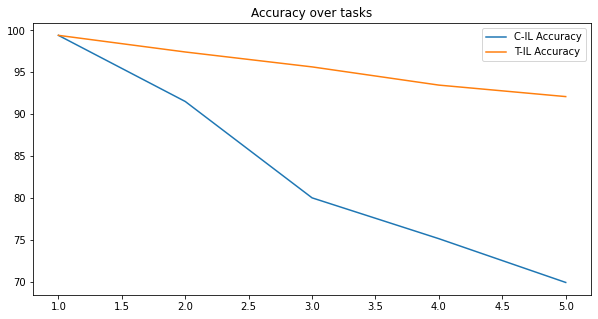

In [ ]:
# Train using DER on CIFAR-10
NAMES[SequentialCIFAR10.NAME] = SequentialCIFAR10
dataset_cifar = get_dataset("seq-cifar10", 32, True)
model_cifar = get_model(Der, backbone=dataset_cifar.get_backbone(), loss=dataset_cifar.get_loss(), lr=0.03, buffer_size=500, minibatch_size=32, alpha=0.3, transform=dataset_cifar.get_transform())
train(model_cifar, dataset_cifar, 50, 40, 4)

In [ ]:
import os
import sys
import pickle
#file_name_1 = "train_data200.pkl"
#file_name_2 = "test_data200.pkl"
#open_file = open(file_name_1, "wb")
#pickle.dump(train_data, open_file)
#open_file.close()
#open_file = open(file_name_2, "wb")
#pickle.dump(test_data, open_file)
#open_file.close()

# Import CIFAR-10 dataset with cluter labels (used in this case to
# assess the performance of the baseline without classifing clusters)
train_path = "/home/marco_palumbo/data/train_data200_6.pkl"
test_path = "/home/marco_palumbo/data/test_data200_6.pkl"
open_file_1 = open(train_path, "rb")
open_file_2 = open(test_path, "rb")
train_data = pickle.load(open_file_1)
test_data = pickle.load(open_file_2)
open_file_1.close()
open_file_2.close()

print(train_data[0][0].shape)

(8000, 32, 32, 3)


In [25]:
from torch.utils.data import TensorDataset, DataLoader
# Create data loaders for train and test data from the dataset containing clusters labels

def get_dataloaders(train_data: Tuple, test_data: Tuple, batch_size: int):
  train_x = torch.tensor(train_data[0])
  train_x = train_x.transpose(1, 3)
  train_x = train_x.transpose(2, 3)
  train_y = torch.tensor(train_data[1])
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
  test_x = torch.tensor(test_data[0])
  test_x = test_x.transpose(1, 3)
  test_x = test_x.transpose(2, 3)
  test_y = torch.tensor(test_data[1])
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)
  # Separate data: 9000 for train, 1000 for test
  train_x = torch.cat((train_x, test_x[0:1000]))
  train_y = torch.cat((train_y, test_y[0:1000]))
  train_l = torch.cat((train_l, test_l[0:1000]))
  test_x = test_x[1000:2000]
  test_y = test_y[1000:2000]
  test_l = test_l[1000:2000]
  # Create loaders
  my_dataset_train = TensorDataset(train_x, train_y, train_l)
  my_dataset_test = TensorDataset(test_x, test_y, test_l)
  my_dataloader_train = DataLoader(my_dataset_train, batch_size, True) # create dataloader and shuffle data
  my_dataloader_test = DataLoader(my_dataset_test, batch_size, True)
  return my_dataloader_train, my_dataloader_test

In [26]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from typing import Tuple
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def mask_classes(outputs: torch.Tensor, dataset: ContinualDataset, k: int) -> None:
    """
    Given the output tensor, the dataset at hand and the current task,
    masks the former by setting the responses for the other tasks at -inf.
    It is used to obtain the results for the task-il setting.
    :param outputs: the output tensor
    :param dataset: the continual dataset
    :param k: the task index
    """
    outputs[:, 0:k * dataset.N_CLASSES_PER_TASK] = -float('inf')
    outputs[:, (k + 1) * dataset.N_CLASSES_PER_TASK:
               dataset.N_TASKS * dataset.N_CLASSES_PER_TASK] = -float('inf')


def evaluate_cifar(model: ContinualModel, dataset: ContinualDataset, test_loaders: list, last=False) -> Tuple[list, list]:
    """
    Evaluates the accuracy of the model for each past task.
    :param model: the model to be evaluated
    :param dataset: the continual dataset at hand
    :return: a tuple of lists, containing the class-il
             and task-il accuracy for each task
    """
    status = model.net.training
    model.net.eval()
    accs, accs_mask_classes = [], []
    test_transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    
    for k, test_loader in enumerate(test_loaders):
      # k = indice del task (da 0 a 4), last = flag per indicare l'ultimo task (quello corrente da valutare)
      # il numero di test_loader è di 5 (quanti i task)
        if last and k < len(test_loaders) - 1:
            continue
        correct, correct_mask_classes, total = 0.0, 0.0, 0.0
        for data in test_loader:
            inputs, labels, cluster_labels = data
            # Apply test transformation
            transf_inputs = torch.Tensor()
            for j in range(inputs.shape[0]):
              input = inputs[j].permute(1, 2, 0)
              input = np.array(input)
              img = test_transf(input)
              img = img.permute(1, 2, 0)
              transf_inputs = torch.cat((transf_inputs, img))
            transf_inputs = transf_inputs.unsqueeze(0)
            transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
            transf_inputs = transf_inputs.permute(0, 3, 1, 2)
            transf_inputs = transf_inputs.float()
            labels = labels.long()
            cluster_labels = cluster_labels.long()
            labels = labels.squeeze(1)
            cluster_labels = cluster_labels.squeeze(1)
            transf_inputs, labels = transf_inputs.to(model.device), labels.to(model.device)
            cluster_labels = cluster_labels.to(model.device)
            with torch.no_grad():
              if 'class-il' not in model.COMPATIBILITY:
                  outputs = model(transf_inputs, k) # fornisco anche l'indice del task
              else:
                  outputs = model(transf_inputs) # shape = [32, 10], tranne per l'ultimo mini-batch

            _, pred = torch.max(outputs.data, 1) # label predette dal modello per la classificazione delle immagini (batch di 32, tranne l'ultimo)
            correct += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette
            total += labels.shape[0] # numero di campioni totali valutati fino a questo momento per il task corrente
            
            if dataset.SETTING == 'class-il': # con seq-mnist siamo in questo scenario
                mask_classes(outputs, dataset, k) # maschero gli output delle classi non appartenenti al task corrente (per lo scenario Task IL)
                _, pred = torch.max(outputs.data, 1)
                correct_mask_classes += torch.sum(pred == labels).item() # calcolo il numero di predizioni corrette per lo scenario T-IL
      
        # Calcolo l'accuratezza per i due scenari (C-IL e T-IL)
        accs.append(correct / total * 100
                    if 'class-il' in model.COMPATIBILITY else 0)
        accs_mask_classes.append(correct_mask_classes / total * 100)

    model.net.train(status) # Resetto lo stato di training
    return accs, accs_mask_classes


def train_cifar(model: ContinualModel, dataset: ContinualDataset, train_data: list, test_data: list, n_epochs: int, checkpoint_epoch: int, task: int, save: bool =True) -> Tuple[list, list]:
    """
    The training process, including evaluations and loggers.
    :param model: the module to be trained
    :param dataset: the continual dataset at hand
    :param args: the arguments of the current execution
    """
    model.net.to(model.device)
    results, results_mask_classes = [], []
    accuracy = []
    total_loss = []
    test_loaders = list()
    train_transf = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomCrop(32, padding=4),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])
    checkpoint_epoch_passed = checkpoint_epoch

    for t in range(dataset.N_TASKS):
        model.net.train()
        train_loader, test_loader = get_dataloaders(train_data[t], test_data[t], dataset.batch_size)
        test_loaders.append(test_loader)
        if t:
            accs = evaluate_cifar(model, dataset, test_loaders, last=True)
            results[t-1] = results[t-1] + accs[0]
            if dataset.SETTING == 'class-il':
                results_mask_classes[t-1] = results_mask_classes[t-1] + accs[1] # salvo anche le accuratezze per lo scenario T-IL

            # Identificare i 2 cluster che si attivano maggiormente in corrispondenza delle 2 classi del nuovo task
            # e aggiornare i pesi del classificatore in CL.
            # NOTA: i dati di train vengono passati senza essere trasformati!
            #update_weights(model, train_loader, n_clusters, t+t, t+t+1, True)
            #model.net.classifier_cluster.apply(xavier)

        if task is not None and t < task:
          # Load parameters for old tasks
          weights_directory = "/home/marco_palumbo/saved_models/DER_cifar_clustering/model_%d_epoch_%d_task.pt" % (49, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = 49 + 1
        elif task is not None and t == task:
          # Load parameters for current task
          weights_directory = "/home/marco_palumbo/saved_models/DER_cifar_clustering/model_%d_epoch_%d_task.pt" % (checkpoint_epoch_passed, t)
          model.load_state_dict(torch.load(weights_directory, map_location=get_device()))
          checkpoint_epoch = checkpoint_epoch_passed
        else: 
          checkpoint_epoch = 0
        for epoch in range(checkpoint_epoch, n_epochs):
            sum_total_loss = 0
            for i, data in enumerate(train_loader):
                  inputs, labels, cluster_lab = data
                  # Apply train transformation
                  transf_inputs = torch.Tensor()
                  for j in range(inputs.shape[0]):
                    input = inputs[j].permute(1, 2, 0)
                    input = np.array(input)
                    img = train_transf(input)
                    img = img.permute(1, 2, 0)
                    transf_inputs = torch.cat((transf_inputs, img))
                  transf_inputs = transf_inputs.unsqueeze(0)
                  transf_inputs = transf_inputs.reshape(inputs.shape[0], 32, 32, 3)
                  transf_inputs = transf_inputs.permute(0, 3, 1, 2)
                  transf_inputs = transf_inputs.float()
                  labels = labels.long()
                  cluster_lab = cluster_lab.long()
                  labels = labels.squeeze(1)
                  cluster_lab = cluster_lab.squeeze(1)
                  transf_inputs, labels = transf_inputs.to(model.device), labels.to(
                      model.device)
                  cluster_lab = cluster_lab.to(model.device)
                  inputs = inputs / 255
                  loss = model.observe(transf_inputs, labels, inputs)
                  sum_total_loss += loss
                  progress_bar(i, len(train_loader), epoch, t, loss)
                  #progress_bar_clustering(i, len(train_loader), epoch, t, total_loss, classification_loss, clustering_loss)
                  # Save parameters every 10 epochs
                  if(save and (epoch % 10 == 0 or epoch == 49)):
                    torch.save(model.state_dict(), "/home/marco_palumbo/saved_models/DER_cifar_clustering/model_%d_epoch_%d_task.pt" % (epoch, t))

            total_loss.append(sum_total_loss / len(train_loader))
        accs = evaluate_cifar(model, dataset, test_loaders) # calcolo dell'accuratezza
        results.append(accs[0]) # accuratezza per C-IL
        results_mask_classes.append(accs[1]) # accuratezza per T-IL

        mean_acc = np.mean(accs, axis=1) # calcolo l'accuratezza media (acc / num_task) per i 2 scenari ed il clustering
        accuracy.append(mean_acc)
        print_mean_accuracy(mean_acc, t + 1, dataset.SETTING)
        #print_mean_accuracy_clustering(mean_acc, t + 1, dataset.SETTING)
  
    # Plotting dell'accuratezza media
    plt.figure(figsize=(10,5))
    plt.title("Accuracy over tasks")
    plt.plot([1, 2, 3, 4, 5], accuracy) # Num task vs accuracy
    plt.legend(loc="lower left")
    plt.gca().legend(('C-IL Accuracy','T-IL Accuracy'))
    
    # Plotting della loss
    ax = plt.figure(figsize=(10,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Loss over tasks")
    plt.plot(np.arange(len(total_loss)), total_loss, label="Classification Loss")
    plt.legend(loc="upper right")
    return results, results_mask_classes

/home/marco_palumbo/miniconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))
/tmp/ipykernel_1466/314995865.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_l = torch.tensor(train_data[2].clone().detach(), dtype=torch.float32)
/tmp/ipykernel_1466/314995865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_l = torch.tensor(test_data[2].clone().detach(), dtype=torch.float32)

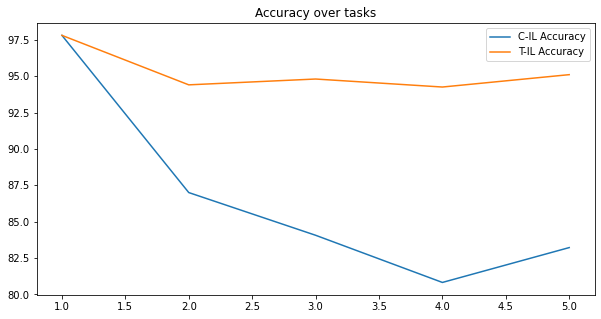

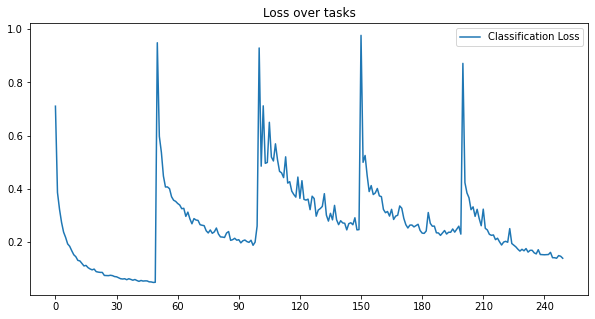

In [ ]:
# Train Cifar-10 with DER baseline using custom dataset
NAMES[SequentialCIFAR10.NAME] = SequentialCIFAR10
dataset_cifar = get_dataset("seq-cifar10", 32, True)
model_cifar = get_model(Der, backbone=dataset_cifar.get_backbone(), loss=dataset_cifar.get_loss(), lr=0.03, buffer_size=5120, minibatch_size=32, alpha=0.3, transform=dataset_cifar.get_transform())
results, results_mask_classes = train_cifar(model_cifar, dataset_cifar, train_data, test_data, 50, 0, None, True)